In [10]:
import pandas as pd
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from boostaroota import BoostARoota
import shap
from boruta import BorutaPy
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv'
df = pd.read_csv(path)

In [3]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,2015,163.000000,-1.450726,0.5,332,-0.018070,170,-9,0.10,50.339080,engine_ignition
1,2014,108.451384,2.233679,0.4,425,-0.849765,173,16,0.10,44.367816,break_bug
2,2010,167.738026,-8.024895,-0.8,50,0.134024,171,-9,0.10,44.902299,engine_check
3,2018,167.000000,-0.201363,2.0,224,-0.985060,173,-2,0.52,44.770115,engine_check
4,2019,183.000000,14.666233,0.8,351,0.606498,170,13,0.10,45.241379,another_bug
...,...,...,...,...,...,...,...,...,...,...,...
1865,2014,114.849701,-8.475321,-0.3,339,-1.062402,170,9,0.10,44.419540,gear_stick
1866,2011,152.198802,10.065974,0.2,241,-0.365611,174,-1,0.10,43.488506,engine_check
1867,2014,118.000000,9.569632,0.5,450,0.290211,171,-3,0.10,44.477011,wheel_shake
1868,2012,188.521004,14.327537,-0.7,392,1.218379,174,1,0.00,48.706897,electro_bug


# Линейная корреляция

/run/user/1000/ipykernel_5390/760304135.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.dropna().corr()


<Axes: >

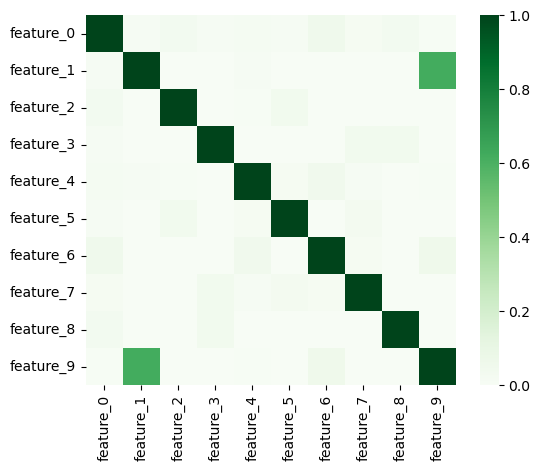

In [11]:
corrs = df.dropna().corr()
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

**Преимущества и недостатки фильтрации по корреляции?**

* ✅ Быстро и понятно
* ❌ Не улавливает нелинейные зависимости
* ❌ Упускает парные зависимости
* ❌ Не подходит для категорий (нужен другой стат. критерий)


# Phik

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


NameError: name 'plt' is not defined

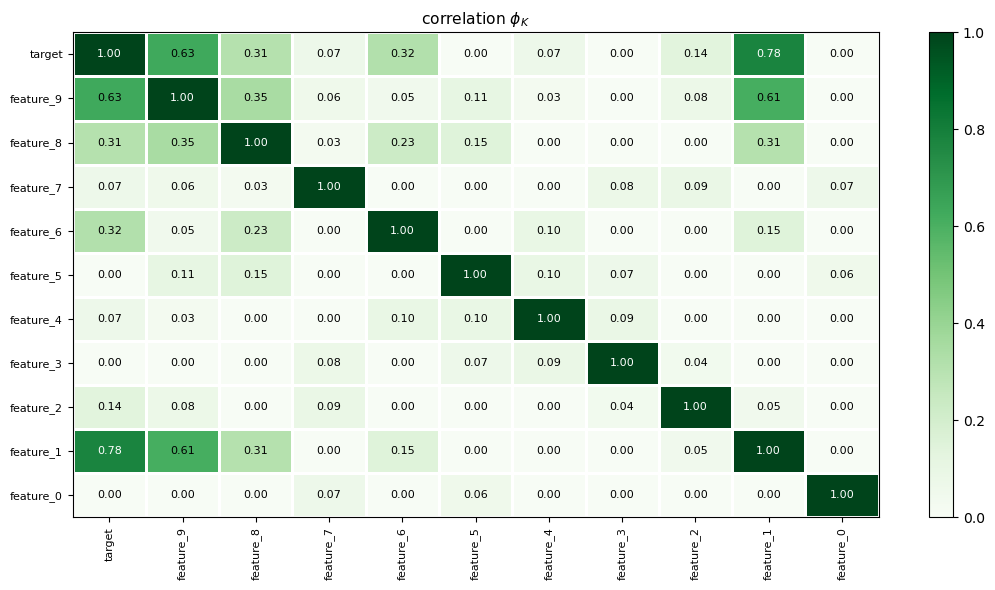

In [13]:
phik_overview = df.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


NameError: name 'plt' is not defined

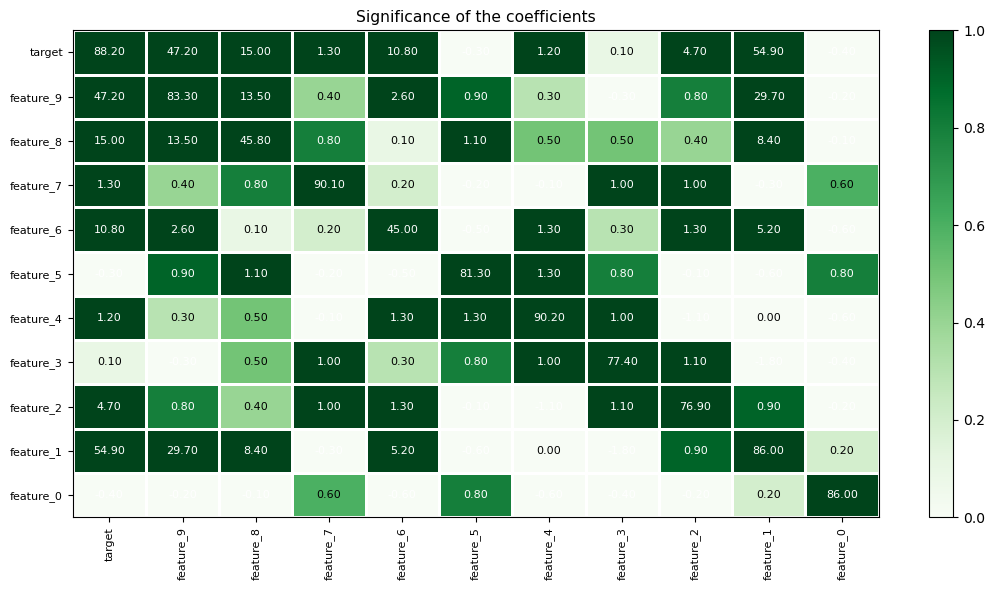

In [15]:
significance_overview = df.significance_matrix().fillna(0).round(1)

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

**Преимущества и недостатки метода `phik`?**

* ✅ Работает с категориальными значениями!
* ✅ Ловит нелинейные зависимости!
* ❌ Не ловит парные зависимости
* ❌ Долго считается, если много признаков

# Shap

In [17]:
X = df.drop(columns=['target'])
y = df.target

In [21]:
model = CatBoostClassifier(random_state=42,
                           thread_count=-1)
model.fit(X, y,
          verbose=100, plot=True, 
          early_stopping_rounds=100)

iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.081693
0:	learn: 1.9690127	total: 125ms	remaining: 2m 4s
100:	learn: 0.5284886	total: 2.23s	remaining: 19.8s
200:	learn: 0.4050902	total: 3.49s	remaining: 13.9s
300:	learn: 0.3281276	total: 4.81s	remaining: 11.2s
400:	learn: 0.2711340	total: 6.97s	remaining: 10.4s
500:	learn: 0.2218551	total: 8.65s	remaining: 8.61s
600:	learn: 0.1878033	total: 10.1s	remaining: 6.73s
700:	learn: 0.1615308	total: 11.6s	remaining: 4.96s
800:	learn: 0.1394795	total: 13.1s	remaining: 3.27s
900:	learn: 0.1200086	total: 15s	remaining: 1.65s
999:	learn: 0.1062787	total: 16.7s	remaining: 0us


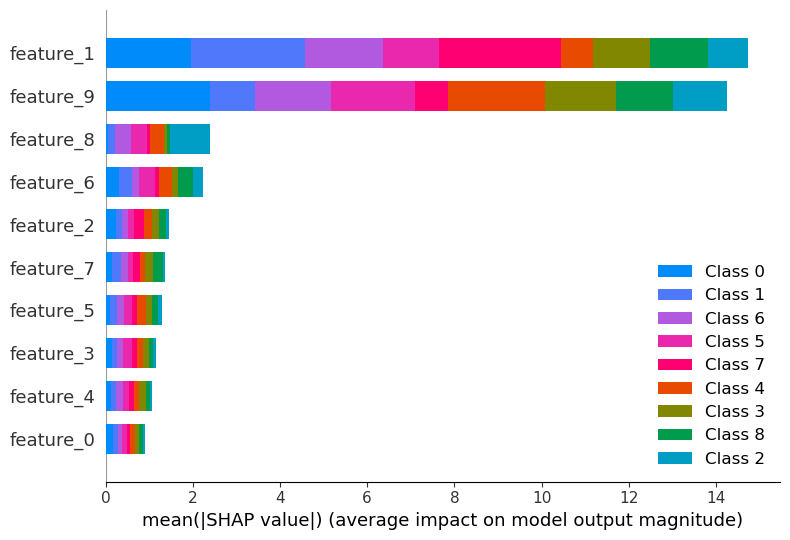

In [23]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X, label=y)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X, max_display = 25)

## <center>😼 CatBoost feature selection (рекурсивные методы)</center>

<div class="alert alert-info">    

**Суть рекурсивных алгоритмов: удаляем признаки и смотрим, уменьшится ли качество. Если уменьшилось, значит признак вредный**    
    
    
<p id="g4"></p>     
    
В библиотеке CatBoost есть встроенный метод для отбора признаков [select_features](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features), который поддерживает 3 алгоритма отбора признаков - параметр `algorithm`:
* `RecursiveByPredictionValuesChange` - самый быстрый и достаточно точный
* `RecursiveByLossFunctionChange` - оптимальный по соотношению точность/скорость
* `RecursiveByShapValues` (по умолчанию) - наиболее точный, но самый ресурсозатратный <br>
Если не хватает времени (ресурсов) на самый точный алгоритм, можно попробовать другие.

In [27]:
summary = model.select_features(X, y,
                      features_for_select='0-9',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [28]:
# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['feature_1', 'feature_2', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
Best loss: 0.14980415932250804


In [29]:
summary

{'selected_features': [1, 2, 4, 5, 6, 7, 8, 9],
 'eliminated_features_names': ['feature_0', 'feature_3'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2],
  'loss_values': [0.10627874488135618,
   0.12197751113786932,
   0.14980415932250804]},
 'eliminated_features': [0, 3],
 'selected_features_names': ['feature_1',
  'feature_2',
  'feature_4',
  'feature_5',
  'feature_6',
  'feature_7',
  'feature_8',
  'feature_9']}

# <center>🧠 Мысли и советы по отбору признаков:
    
    
<p id="6"></p> 

<div class="alert alert-info">
  
* **Рекурсивные** методы отбора самые **точные**, но самые долгие. (Особенно, когда данных много и при этом фичей > 30)
* Перед тем как применять какой-либо из алгоритмов отбора, полезно проводить начальный EDA и откидывать явный мусор.
* Нельзя ограничиваться каким-то одним методом, пусть даже в предыдущих задачах он себя отлично показал.

<div class="alert alert-info">
    
* Если не хватает ресурсов для работы какого-нибудь алгоритма, попробуйте применить его к меньшему сэмплу данных. <br>
* Можно взять 20% от ваших данных и прогнать алгоритм отбора, только следите за тем, чтобы сэмпл был репрезентативен
* Постоянно экспериментируйте и сверяйтесь с лидербордом. Всегда есть риски отсеять что-то полезное.
    

<div class="alert alert-info">
    
* Менее точными методами можно преоритизировать удаление признаков.
* Методы фильтрации фичей можно объединять между собой. Например: удалять те, которые отфильтровались несколькими способами 
* При ограниченном времени сделайте выбор в пользу __feature engeneering__'а. Так как новые сильные признаки могут добавить десятки % к точности, а фильтрация уже имеющихся, скорее всего, единицы процентов.

# HomeWork

In [30]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv'
df = pd.read_csv(path)

In [31]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target_reg,target_class
0,0,4.101552,173,1,3.405865,88182,157.168032,1.973071e+07,0,1,...,2015,191.996603,2020,0.10,0,174,9,4.76,57.15,engine_ignition
1,0,4.303506,173,1,-2.218952,86897,121.805143,1.594185e+07,0,0,...,2015,193.547718,2015,0.10,1,174,7,4.26,60.82,engine_ignition
2,0,4.246379,174,1,-3.740321,44604,175.889164,2.127630e+07,0,0,...,2013,177.922027,2019,0.10,1,174,6,5.98,46.51,engine_ignition
3,0,4.342874,172,1,3.139031,114610,151.653445,2.250440e+07,0,0,...,2017,110.165268,2016,0.70,1,174,20,4.42,30.71,gear_stick
4,1,4.140287,148,0,-4.022916,114851,159.547387,1.163474e+07,0,0,...,2017,190.915943,2020,0.10,0,174,25,4.28,59.18,engine_fuel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,0,5.345345,173,1,-1.504180,42550,176.567014,1.208544e+07,0,0,...,2013,109.836630,2018,0.10,1,174,8,1.92,31.75,break_bug
1866,0,4.042874,172,1,-1.079727,65913,128.338875,1.672780e+07,0,1,...,2014,196.975349,2016,0.10,0,174,16,3.84,50.87,engine_overheat
1867,0,3.977816,174,1,-3.001480,62873,124.795590,1.823968e+07,0,1,...,2014,179.247675,2016,0.10,0,174,14,4.04,54.30,engine_ignition
1868,0,4.540920,172,1,1.771542,80826,131.572570,1.167350e+07,0,0,...,2015,142.000000,2019,0.10,1,174,5,2.22,56.62,engine_check


In [34]:
df['feature_11']

0       24
1        2
2       27
3       49
4        4
        ..
1865     0
1866    33
1867    44
1868    43
1869     9
Name: feature_11, Length: 1870, dtype: int64

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg']


Not enough unique value for variable feature_17 for analysis 1. Dropping this column


NameError: name 'plt' is not defined

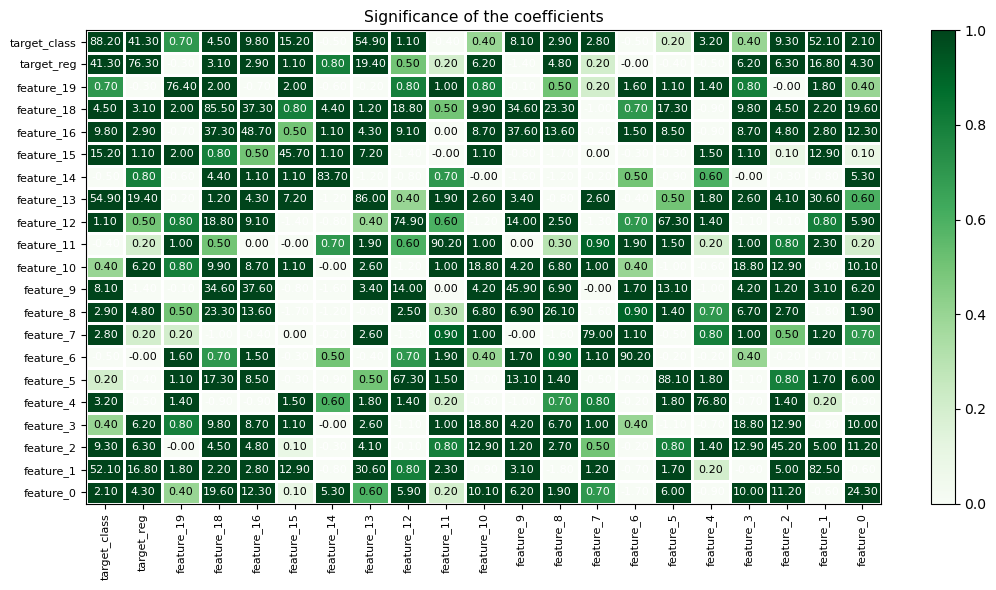

In [32]:
significance_overview = df.significance_matrix().fillna(0).round(1)

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg']


Not enough unique value for variable feature_17 for analysis 1. Dropping this column


NameError: name 'plt' is not defined

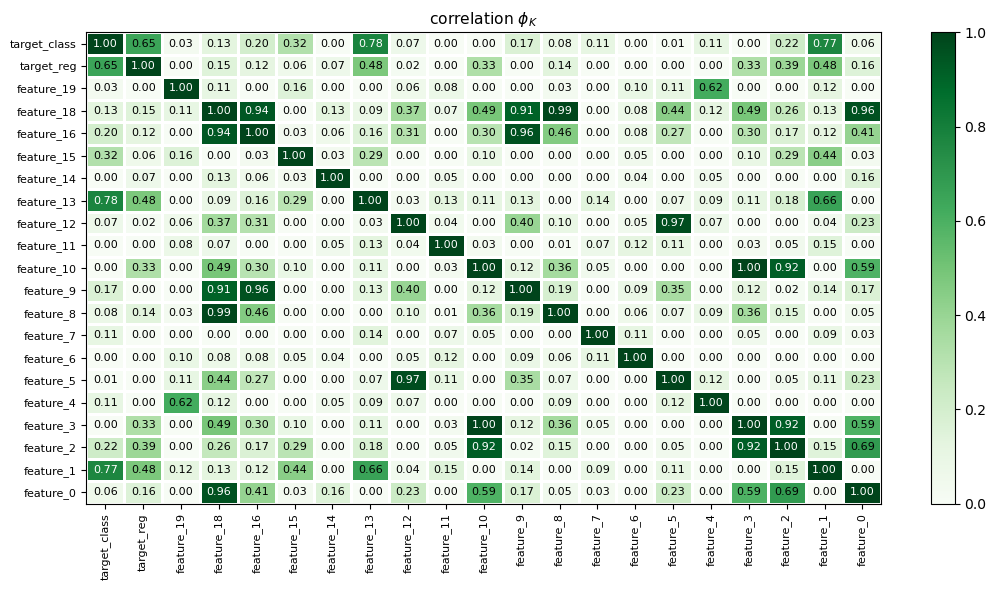

In [33]:
phik_overview = df.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [ ]:
X = 

In [ ]:
model = CatBoostClassifier(random_state=42,
                           thread_count=-1)
model.fit(X, y,
          verbose=100, plot=True, 
          early_stopping_rounds=100)

In [3]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task3_310f.csv'
df = pd.read_csv(path)

In [4]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,target
0,-0.917,-0.313,-0.69,0.771,0.086,44800,1.38,42902,-0.40,0.51,...,49118,43122,-0.99,-0.68,-0.07,8006,-0.166,0.40,173,gear_stick
1,1.406,0.324,0.88,0.104,1.275,2097,-0.53,19640,0.25,1.12,...,23477,26027,0.20,0.24,-0.13,9512,0.816,1.28,173,wheel_shake
2,0.908,0.652,0.62,0.482,0.768,21520,0.88,7491,1.07,0.58,...,19738,5099,1.53,0.18,0.69,35420,0.994,0.16,170,break_bug
3,-0.527,-0.892,-0.12,-0.764,-0.811,7649,0.61,12421,-1.78,0.21,...,27290,17042,-1.84,-0.76,-0.10,36626,0.867,-2.71,170,another_bug
4,0.050,0.646,-2.51,0.510,-0.755,27745,0.00,38967,1.08,1.46,...,43419,6234,-0.97,-0.62,0.91,35750,0.076,-0.07,173,electro_bug
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,-0.960,-0.699,-0.04,0.238,-1.751,13201,0.91,39896,0.33,-1.05,...,37689,13329,-0.57,0.19,-0.54,16087,-0.487,-0.35,172,gear_stick
1632,0.088,-0.612,1.30,0.716,-0.039,46709,-0.35,17423,0.78,-1.61,...,18623,28892,0.65,-0.60,-0.96,38816,-1.602,-2.95,171,gear_stick
1633,-0.577,-1.050,-1.05,0.160,1.644,26344,-0.17,47545,0.35,0.51,...,23284,22642,-1.22,-1.03,0.82,27475,-0.302,1.88,170,another_bug
1634,1.074,-1.027,-0.53,-0.519,-1.341,42592,0.16,27582,0.15,0.65,...,23016,42662,-1.15,0.24,0.84,19920,0.323,-0.05,174,electro_bug


In [14]:
model = CatBoostClassifier(random_state=42,
                           thread_count=-1)
model.fit(X, y,
          verbose=100, plot=True, 
          early_stopping_rounds=100)

summary = model.select_features(X, y,
                      features_for_select='0-309',
                      num_features_to_select=10,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

iteritems is deprecated and will be removed in a future version. Use .items instead.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.081138
0:	learn: 1.9907286	total: 1.45s	remaining: 24m 13s
100:	learn: 0.5146544	total: 1m 14s	remaining: 11m
200:	learn: 0.3180530	total: 2m 23s	remaining: 9m 31s
300:	learn: 0.2326517	total: 3m 33s	remaining: 8m 15s
400:	learn: 0.1763633	total: 4m 43s	remaining: 7m 3s
500:	learn: 0.1363206	total: 5m 53s	remaining: 5m 52s
600:	learn: 0.1103381	total: 7m 3s	remaining: 4m 41s
700:	learn: 0.0890897	total: 8m 12s	remaining: 3m 30s
800:	learn: 0.0742432	total: 9m 21s	remaining: 2m 19s
900:	learn: 0.0619418	total: 10m 30s	remaining: 1m 9s
999:	learn: 0.0528014	total: 11m 40s	remaining: 0us


KeyboardInterrupt: 

In [15]:
model.fit(X, y,
          verbose=100, plot=True, 
          early_stopping_rounds=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.081138
0:	learn: 1.9907286	total: 874ms	remaining: 14m 32s
100:	learn: 0.5146544	total: 1m 10s	remaining: 10m 24s
200:	learn: 0.3180530	total: 2m 18s	remaining: 9m 9s
300:	learn: 0.2326517	total: 3m 25s	remaining: 7m 57s
400:	learn: 0.1763633	total: 4m 33s	remaining: 6m 49s
500:	learn: 0.1363206	total: 5m 43s	remaining: 5m 42s
600:	learn: 0.1103381	total: 6m 53s	remaining: 4m 34s
700:	learn: 0.0890897	total: 8m 2s	remaining: 3m 25s
800:	learn: 0.0742432	total: 9m 11s	remaining: 2m 17s
900:	learn: 0.0619418	total: 10m 21s	remaining: 1m 8s
999:	learn: 0.0528014	total: 11m 30s	remaining: 0us


In [21]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi.loc[:10, :]

,Feature Id,Importances
0,feature_141,29.971430
1,feature_234,23.427756
2,feature_59,7.764092
3,feature_309,1.976570
4,feature_81,0.452120
5,feature_202,0.375178
6,feature_161,0.353457
7,feature_43,0.341612
8,feature_263,0.322266
9,feature_9,0.314623
